# Problem

A set of different weights are placed at regular intervals on a plank. Assume the plank to be weightless and the weights to have round values (e.g. 1 Kg, 3 Kg...). The plank has slots where it can be pinned. The slots rest between the weights. An example plank would be:

![plank image](https://github.com/ne1s0n/coding_excercises/raw/master/data/plank.png "Plank image")

Where the black elements are weights and red-rimmed dark-brown squares are pin slots. 

To solve the exercise find the point where to pin the plank that best balances it (i.e. the total weight left and right of the selected point are as similar as possible).

# Setup

Our 'plank' will be a list of random integers. The problem does not state the limits of the weights (which we assume being positive) or the length of the plank (again, positive). As a first step we write a function that creates a new list filled with random integers. We'll set default values for all arguments to simplify our life later on.  
To be able to pick random numbers we'll use the [random module](https://docs.python.org/3/library/random.html)

In [1]:
import random

#a handy function to create a plank
def get_plank(
    min_weight = 0,
    max_weight = 100,
    plank_length = 10): #not to be confused with Planck length

    #the function random.randint returns a single random integer.
    #To fill a list we need to loop through it

    return [random.randint(min_weight, max_weight) for i in range(plank_length)]

#let's test the function
print("Here's my plank: " + str(get_plank()))

Here's my plank: [85, 21, 95, 70, 92, 33, 9, 11, 34, 44]


# A first, inefficient solution

Our first solution will go like this: for each possible position we compute the unbalancedness (difference between weights before and after the pin). We then select the position with the minimum unbalancedness.  

To improve code reusability and testing our solution goes into a function.

In [2]:
def balance1(plank):
    #it's a matter of finding a minimum, so...
    current_min_value = float("inf")
    current_min_pos   = None
    
    #I need to loop over spaces between weights.
    #Unfortunately lists are indexed by cell, not by "space between cell", so...
    for i in range(len(plank) - 1):
        #computing the weights at the current position
        weights_before = 0
        weights_after  = 0
        for j in range(len(plank)):
            if j <= i:
                weights_before += plank[j]
            else:
                weights_after += plank[j]
        
        #how balanced are we here? let's compute the difference
        delta = abs(weights_before - weights_after)
        
        #should we update the minimum?
        if delta < current_min_value:
            current_min_value = delta
            current_min_pos = i
    
    #and we are done
    return current_min_pos, current_min_value

Let's test the function!

In [3]:
#let's create a short plank, so it's easy to check the values by hand
my_plank = get_plank(plank_length=4)

#invoking the function
pos, value = balance1(my_plank)

#printing the results
print('Tested plank: ' + str(my_plank))
print('Found balance after weight position: ' + str(pos)) #this points to the space between slots
print('Residual unbalance: ' + str(value))

Tested plank: [78, 76, 58, 9]
Found balance after weight position: 0
Residual unbalance: 65


It seems to work, but what happens in a limit case?

In [4]:
#let's create a unitary plank...
my_plank = get_plank(plank_length=1)

#invoking the function
pos, value = balance1(my_plank)

#printing the results
print('Tested plank: ' + str(my_plank))
print('Found balance after weight position: ' + str(pos)) #this points to the space between slots
print('Residual unbalance: ' + str(value))

Tested plank: [19]
Found balance after weight position: None
Residual unbalance: inf


Well... it a single slot plank, so there's no way it can be balanced. We could either accept "None" as a valid response ("it's not a bug, it's a feature!") or tweak the function so it is initialized to the first position. Both solutions have their pros and cons, you decide what you prefer.

# A more efficient solution

Our previous solution used a loop-within-a-loop, so the expected execution time scales with the square of the length of the the plank. But a lot of computation in that function is adding the same numbers again and again.

Consider this: if you start from one extreme of the plank all the weight is "after" your selected point, e.g.:

In [5]:
#   [a  b  c  d]
# ^               all weight (a+b+c+d) is after the current position

Then we do a step forward, and one slot is removed from the "after" bin and goes in the "before" bin

In [6]:
#   [a  b  c  d]
#     ^           before is (a), after is (b+c+d)

If we can keep track of how the weight changes we don't need a loop-within-a-loop anymore. Let's implement it!

In [7]:
def balance2(plank):
    #at the beginning all weight is in the after bin
    before_bin = 0
    after_bin = sum(plank)
    
    #the current position is before slot zero, so...
    current_min_value = abs(after_bin - before_bin)  #this is equal to after_bin
    current_min_pos   = -1
    
    #we now implement the "moving a step forward" part. For each new position we
    #remove something from after_bin and add it to before_bin. We also keep track
    #of the found minimum
    for i in range(len(plank)):
        #updating the bins
        before_bin += plank[i]
        after_bin  -= plank[i]
        
        #let's compute current delta
        delta = abs(after_bin - before_bin)
        
        #should we update the minimum?
        if delta < current_min_value:
            current_min_value = delta
            current_min_pos = i

    #and we are done
    return current_min_pos, current_min_value

Let's test the function, and let's compare results with the previous implementation.

In [8]:
#testing the functions on a new 20-slots plank
my_plank = get_plank(plank_length = 20)
print('Tested plank: ' + str(my_plank))

#invoking the functions
pos1, value1 = balance1(my_plank)
pos2, value2 = balance2(my_plank)

#printing the results
print('Returned balance point, residual unbalancedness:')
print('- for function balance1: ' + str(pos1) + ', ' + str(value1))
print('- for function balance2: ' + str(pos2) + ', ' + str(value2))

Tested plank: [99, 85, 13, 48, 77, 65, 82, 61, 75, 84, 40, 40, 21, 72, 32, 0, 21, 18, 24, 70]
Returned balance point, residual unbalancedness:
- for function balance1: 7, 33
- for function balance2: 7, 33


They return the same values. Good! Actually the results would differ in the limit case of a single-slot list...

# Test performances

The first function is supposed to be slower than the second one, but we should really test the hypothesis. We want to show how the execution time grows when the length of the plank grows.

To measure execution times we use the [timeit module](https://docs.python.org/3.8/library/timeit.html)

In [9]:
import timeit

#we'll test the execution times at these lengths
tested_lengths = [50, 100, 150, 200, 250, 300]

#since execution times of the same code can vary, we actually execute
#each function this number of times (and then take the average)
R = 100

#room for storing the results
times1 = []
times2 = []

#let's go!
for current_length in tested_lengths:
    #let's build a test plank
    my_plank = get_plank(plank_length = current_length)
    
    #let's invoke each function and record the execution time
    #(the argument globals=globals() is to let the timeit function access our
    #user-defined functions)
    time1 = timeit.timeit("balance1(my_plank)", number = R, globals=globals()) / R
    time2 = timeit.timeit("balance2(my_plank)", number = R, globals=globals()) / R

    #keeping track of what we measured
    times1.append(time1)
    times2.append(time2)

At this point we have two lists of measured times. We could print them...

In [10]:
print('Tested plank lengths:' + str(tested_lengths))
print('Execution times, function balance1:' + str(times1))
print('Execution times, function balance2:' + str(times2))

Tested plank lengths:[50, 100, 150, 200, 250, 300]
Execution times, function balance1:[0.0004770925297634676, 0.0018311506899772211, 0.004071378679946065, 0.007124079900095239, 0.011105422140099108, 0.016296528730308638]
Execution times, function balance2:[2.5401060120202602e-05, 5.068510014098138e-05, 7.114787003956736e-05, 9.307347005233169e-05, 0.0001275748503394425, 0.00015588076028507202]


...but a picture is worth a thousand words. Let's plot the values using [matplotlib module.](https://matplotlib.org/3.1.1/index.html)

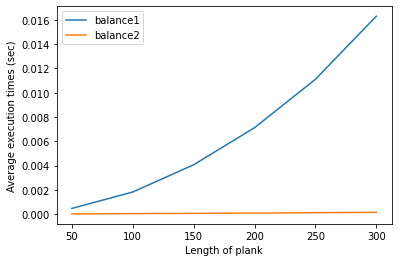

In [11]:
import matplotlib.pyplot as plt

line1, = plt.plot(tested_lengths, times1, label='balance1')
line2, = plt.plot(tested_lengths, times2, label='balance2')

plt.legend(handles=[line1, line2], loc='upper left')
plt.xlabel('Length of plank')
plt.ylabel('Average execution times (sec)')
plt.show()

There's little doubt about which is the most efficient approach. Actually ``balance2()`` performances are so much better that the execution times seem stuck to zero. To show the actual linear increase we need to get rid of ``balance1()`` from the plot.

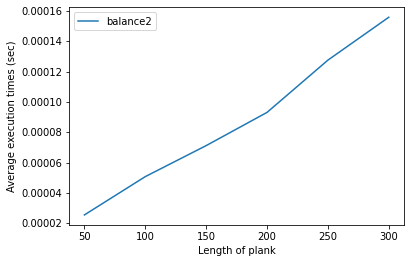

In [12]:
line2, = plt.plot(tested_lengths, times2, label='balance2')
plt.legend(handles=[line2], loc='upper left')
plt.xlabel('Length of plank')
plt.ylabel('Average execution times (sec)')
plt.show()

It's clear that execution times are growing linearly, as expected. Awesome :)

# Next steps...

In this excercise we've worked with lists, loops, functions, execution times and plots. While we have a solid solution to the initial problem there's always room for improvement. Consider:

- how to further improve ``balance2()`` function? Do we really need the full loop? Could we use an early break?
- what happens if we have *magical weights* that can be negative? Does it change anything?
- what about boards? That is, what happens if instead of a 1-dimensional list we have a 2-dimensional matrix? How would the balance point be redefined?


